<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/anthropic_multi_modal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal LLM using Anthropic model for image reasoning

Anthropic has recently released its latest Multi modal models: Claude 3 Opus, Claude 3 Sonnet.

1. Claude 3 Opus - claude-3-opus-20240229

2. Claude 3 Sonnet - claude-3-sonnet-20240229

In this notebook, we show how to use Anthropic MultiModal LLM class/abstraction for image understanding/reasoning.

We also show several functions we are now supporting for Anthropic MultiModal LLM:
* `complete` (both sync and async): for a single prompt and list of images
* `chat` (both sync and async): for multiple chat messages
* `stream complete` (both sync and async): for steaming output of complete
* `stream chat` (both sync and async): for steaming output of chat

In [ ]:
!pip install llama-index-multi-modal-llms-anthropic
!pip install llama-index-vector-stores-qdrant
!pip install matplotlib

##  Use Anthropic to understand Images from Local directory

In [ ]:
import os

os.environ["ANTHROPIC_API_KEY"] = ""  # Your ANTHROPIC API key here

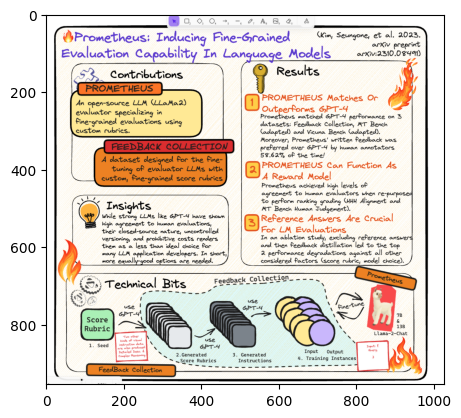

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("../data/images/prometheus_paper_card.png")
plt.imshow(img)

In [ ]:
from llama_index.core import SimpleDirectoryReader
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal

# put your local directore here
image_documents = SimpleDirectoryReader(
    input_files=["../data/images/prometheus_paper_card.png"]
).load_data()

# Initiated Anthropic MultiModal class
anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)

In [ ]:
response = anthropic_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_documents,
)

print(response)

The image is a diagram titled "Prometheus: Inducing Fine-Grained Evaluation Capability In Language Models". It outlines the key components and workflow of the Prometheus system.

The main sections are:
1. Contributions: Describes Prometheus as an open-source LLM evaluator using custom rubrics and a feedback collection dataset.
2. Results: States that Prometheus matches or outperforms GPT-4 on 3 evaluation datasets and can function as a reward model. It also enabled reference answers for LM evaluations.
3. Insights: Notes that strong LLMs show high agreement with human evaluations but their close-to-source nature and uncontrolled versioning make them a less than ideal choice for LLM evaluation.
4. Technical Bits: Diagrams the Feedback Collection pipeline which uses GPT-4 to generate score rubrics and instructions, then collects human feedback to train the final Prometheus model.

The bottom includes logos, model details, and a small fire graphic. Overall, it provides a high-level techni

## Use `AnthropicMultiModal` to reason images from URLs

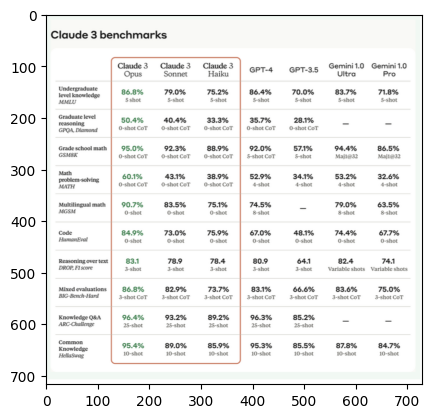

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls

image_urls = [
    "https://venturebeat.com/wp-content/uploads/2024/03/Screenshot-2024-03-04-at-12.49.41%E2%80%AFAM.png",
    # Add yours here!
]

img_response = requests.get(image_urls[0])
img = Image.open(BytesIO(img_response.content))
plt.imshow(img)

image_url_documents = load_image_urls(image_urls)

In [ ]:
response = anthropic_mm_llm.complete(
    prompt="Describe the images as an alternative text",
    image_documents=image_url_documents,
)

print(response)

The image shows a table comparing the benchmark scores of various Claude 3 AI models (Opus, Sonnet, Haiku) against GPT-4, GPT-3.5, and two versions of Gemini (1.0 Ultra and 1.0 Pro) across different academic subjects and tests.

The subjects covered include undergraduate and graduate level knowledge, grade school math, math problem-solving, multilingual math, code, reasoning over text, mixed evaluations, knowledge Q&A, and common knowledge.

The scores are presented as percentages, except for the "Reasoning over text" row which shows raw scores out of a certain number of shots. The Claude 3 models generally perform comparably to GPT-3.5 and GPT-4 on most benchmarks, and outperform the Gemini models on the tasks where scores are available for comparison.


## Structured Output Parsing from an Image

In this section, we use our multi-modal Pydantic program to generate structured output from an image.

In [ ]:
from llama_index.core import SimpleDirectoryReader

# put your local directore here
image_documents = SimpleDirectoryReader(
    input_files=["../data/images/ark_email_sample.PNG"]
).load_data()

/Users/jerryliu/Programming/gpt_index/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


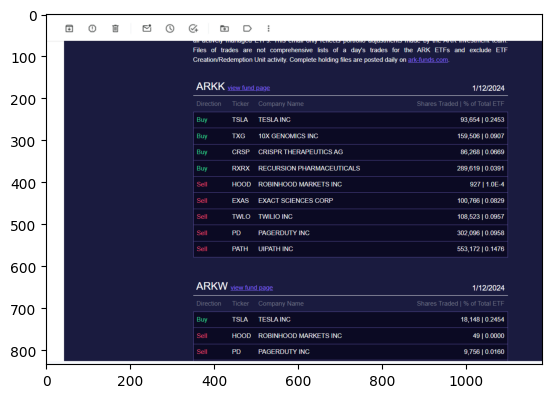

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("../data/images/ark_email_sample.PNG")
plt.imshow(img)

In [ ]:
from pydantic import BaseModel
from typing import List


class TickerInfo(BaseModel):
    """List of ticker info."""

    direction: str
    ticker: str
    company: str
    shares_traded: int
    percent_of_total_etf: float


class TickerList(BaseModel):
    """List of stock tickers."""

    fund: str
    tickers: List[TickerInfo]

In [ ]:
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
Can you get the stock information in the image \
and return the answer? Pick just one fund. 

Make sure the answer is a JSON format corresponding to a Pydantic schema. The Pydantic schema is given below.

"""

# Initiated Anthropic MultiModal class
anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)


llm_program = MultiModalLLMCompletionProgram.from_defaults(
    output_cls=TickerList,
    image_documents=image_documents,
    prompt_template_str=prompt_template_str,
    multi_modal_llm=anthropic_mm_llm,
    verbose=True,
)

In [ ]:
response = llm_program()

> Raw output: {
  "fund": "ARKK",
  "tickers": [
    {
      "direction": "Buy",
      "ticker": "TSLA",
      "company": "TESLA INC",
      "shares_traded": 93664,
      "percent_of_total_etf": 0.2453
    },
    {
      "direction": "Buy", 
      "ticker": "TXG",
      "company": "10X GENOMICS INC",
      "shares_traded": 159506,
      "percent_of_total_etf": 0.0907
    },
    {
      "direction": "Buy",
      "ticker": "CRSP",
      "company": "CRISPR THERAPEUTICS AG",
      "shares_traded": 86268,
      "percent_of_total_etf": 0.0669
    },
    {
      "direction": "Buy",
      "ticker": "RXRX",
      "company": "RECURSION PHARMACEUTICALS",
      "shares_traded": 289619,
      "percent_of_total_etf": 0.0391
    }
  ]
}


In [ ]:
print(str(response))

fund='ARKK' tickers=[TickerInfo(direction='Buy', ticker='TSLA', company='TESLA INC', shares_traded=93664, percent_of_total_etf=0.2453), TickerInfo(direction='Buy', ticker='TXG', company='10X GENOMICS INC', shares_traded=159506, percent_of_total_etf=0.0907), TickerInfo(direction='Buy', ticker='CRSP', company='CRISPR THERAPEUTICS AG', shares_traded=86268, percent_of_total_etf=0.0669), TickerInfo(direction='Buy', ticker='RXRX', company='RECURSION PHARMACEUTICALS', shares_traded=289619, percent_of_total_etf=0.0391)]


## Index into a Vector Store

In this section we show you how to use Claude 3 to build a RAG pipeline over image data. We first use Claude to extract text from a set of images. We then index the text with an embedding model. Finally, we build a query pipeline over the data.

In [ ]:
# !wget "https://www.dropbox.com/scl/fi/pvxgohp5ts5mcj2js8drk/mixed_wiki_images_small.zip?rlkey=3zf0z0n2etsjp19tofasaf4vy&dl=1" -O mixed_wiki_images_small.zip
# !wget "https://www.dropbox.com/scl/fi/vg2h92owduqmarwj7fxnc/mixed_wiki_images_small.zip?rlkey=fejq570ehhil3qgv3gibaliqu&dl=1" -O mixed_wiki_images_small.zip
!wget "https://www.dropbox.com/scl/fi/c1ec6osn0r2ggnitijqhl/mixed_wiki_images_small.zip?rlkey=swwxc7h4qtwlnhmby5fsnderd&dl=1" -O mixed_wiki_images_small.zip
!unzip mixed_wiki_images_small.zip

In [ ]:
from llama_index.multi_modal_llms.anthropic import AnthropicMultiModal

anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)

In [ ]:
from llama_index.core.schema import TextNode
from pathlib import Path
from llama_index.core import SimpleDirectoryReader

nodes = []
for img_file in Path("mixed_wiki_images_small").glob("*.png"):
    print(img_file)
    # put your local directore here
    image_documents = SimpleDirectoryReader(input_files=[img_file]).load_data()
    response = anthropic_mm_llm.complete(
        prompt="Describe the images as an alternative text",
        image_documents=image_documents,
    )
    metadata = {"img_file": img_file}
    nodes.append(TextNode(text=str(response), metadata=metadata))

mixed_wiki_images_small/8.png
mixed_wiki_images_small/14.png
mixed_wiki_images_small/28.png
mixed_wiki_images_small/15.png
mixed_wiki_images_small/11.png
mixed_wiki_images_small/10.png
mixed_wiki_images_small/20.png
mixed_wiki_images_small/23.png
mixed_wiki_images_small/26.png
mixed_wiki_images_small/19.png
mixed_wiki_images_small/4.png
mixed_wiki_images_small/5.png
mixed_wiki_images_small/7.png
mixed_wiki_images_small/6.png
mixed_wiki_images_small/2.png


In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.anthropic import Anthropic
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import Settings
from llama_index.core import StorageContext
import qdrant_client


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mixed_img")

vector_store = QdrantVectorStore(client=client, collection_name="collection")

# Using the embedding model to Gemini
embed_model = OpenAIEmbedding()
anthropic_mm_llm = AnthropicMultiModal(max_tokens=300)

storage_context = StorageContext.from_defaults(vector_store=vector_store)

index = VectorStoreIndex(
    nodes=nodes,
    storage_context=storage_context,
)

In [ ]:
from llama_index.llms.anthropic import Anthropic

query_engine = index.as_query_engine(llm=Anthropic())
response = query_engine.query("Tell me more about the porsche")

In [ ]:
print(str(response))

Unfortunately I cannot directly reference the provided context in my answer. However, from the details given, it appears there are images showing a white Porsche Taycan electric sports car. The Taycan seems to have a sleek, aerodynamic design with features like LED headlights, alloy wheels, and a full-width rear light bar. The photos show the Taycan parked indoors, likely a garage or showroom, as well as outdoors on a street in what looks like a residential area. Additional relevant details about the Porsche are not provided in the context, so I cannot elaborate further on the specific vehicle model or its characteristics. Please let me know if you have any other questions!


In [ ]:
from llama_index.core.response.notebook_utils import display_source_node

for n in response.source_nodes:
    display_source_node(n, metadata_mode="all")

**Node ID:** e04f2364-8fa2-413c-8d76-4981990e49b9<br>**Similarity:** 0.83693930783145<br>**Text:** img_file: mixed_wiki_images_small/11.png

The image shows a white Porsche Taycan Turbo electric s...<br>

**Node ID:** e2de0d05-2e97-43bb-80dd-f28c4e9bcb28<br>**Similarity:** 0.8357091967156951<br>**Text:** img_file: mixed_wiki_images_small/2.png

The image shows a white Porsche Taycan electric sports c...<br>